# Homework 5

Raphaël Attali, Camille Morand-Duval, Niels Nicolas, Debdeep Roy

# Multivariate GARCH models, dynamic conditional correlations during ﬁnancial turmoil


We would like estimate a multivariate volatility model for three stocks or indices of your interest and for which you anticipate that their pairwise correlations have jumped up during the recent ﬁnancial turmoil. You can pick for example stocks from diﬀerent sectors of the S&P500 index. For each asset, download daily adjusted closing prices and transform them in percentage returns.


In [1]:
import pandas as pd
import csv
import re
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

## Extract stock values

#### Comment
We chose companies which have likely benefited from the current events:
* Regeneron Pharmaceuticals Inc. (REGN) - steps towards developing an antibody treatment for the virus
* West Pharmaceutical Services Inc. (WST) - technology for drug delivery
* ServiceNow Inc. (NOW) - workflow apps, useful when working from home

In [2]:
import pandas_datareader as web

def stock_returns(list): 
    
    start = datetime.datetime(2018, 5, 31)
    end = datetime.datetime(2020, 6, 26)
    array = []
    
    for tick in list: 
        stocks = web.DataReader(tick, 'yahoo', start, end)
        
        # log returns
        log_stock = np.log(stocks['Adj Close']) 
        log_returns = np.diff(log_stock)*100

        array.append(log_returns)
    
    array.append(stocks.reset_index()['Date'][1:])
    array = np.transpose(array)
    stocks = pd.DataFrame(array)
    
    return stocks

C:\Users\Camille\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
stocks = stock_returns(['regn', 'wst', 'now'])
stocks = stocks.rename(columns = {0: 'regn', 1: 'wst', 2: 'now', 3: 'date'})
stocks = stocks.set_index('date')
stocks = stocks.astype(float)
stocks.head()

,regn,wst,now
date,,,
2018-06-01,2.160821,0.000000,2.172058
2018-06-04,1.683479,2.453524,1.090395
2018-06-05,-0.076927,-0.294207,1.401574
2018-06-06,1.046295,1.358715,0.177177
2018-06-07,-2.055055,-1.075008,-4.931332


In [4]:
# remove NA values
stocks.isna().sum()

regn    0
wst     0
now     0
dtype: int64

## Question 1
 Make a time series plots of your returns and compute basic descriptive statistics. Compute the unconditional correlation matrix.

### Descriptive statistics

In [5]:
stocks.describe()

,regn,wst,now
count,522.000000,522.000000,522.000000
mean,0.136176,0.168941,0.155517
std,2.278613,1.958744,2.797799
min,-11.081256,-11.321640,-10.324860
25%,-1.088433,-0.688648,-1.229565
50%,0.109530,0.155609,0.245287
75%,1.245988,0.946942,1.509288
max,10.918916,10.631303,12.586031


In [6]:
skewness = stocks.skew()
kurtosis = stocks.kurt()

print('skewness:')
print(skewness)
print(' ')
print('kurtosis:')
print(kurtosis)

skewness:
regn    0.124274
wst     0.542493
now     0.169147
dtype: float64
 
kurtosis:
regn    2.903805
wst     7.226505
now     2.332461
dtype: float64


Text(0.5, 1.0, 'WST')

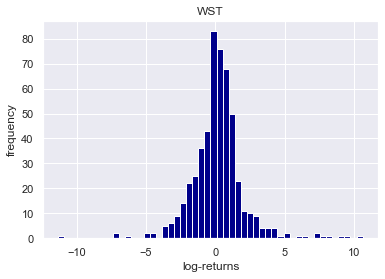

In [7]:
plt.hist(stocks['wst'], bins = 50, color = 'darkblue')
plt.xlabel('log-returns')
plt.ylabel('frequency')
plt.title('WST')

#### Comment
The mean of the log-returns is quite similar over the given period, the standard deviations differ however. The variance of the ServiceNow stock is greater than the ones of both parmaceutical companies, especially West Pharmaceutical Services. The distribution of the log-returns of West Pharmaceutical are dissimilar from the other two companies. Te spread is larger, so are the skewness and kurtosis. This is further conveyed in the histogram. 

### Time series

Text(0.5, 1.0, 'Regeneron Pharmaceutical')

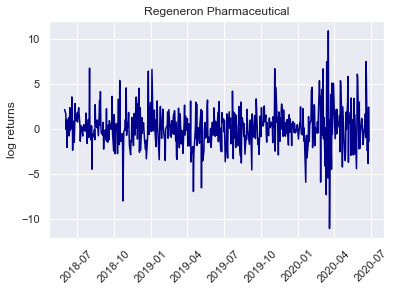

In [8]:
plt.plot(stocks['regn'], color = 'darkblue')
#plt.xlabel('date')
plt.xticks(rotation = 45)
plt.ylabel('log returns')
plt.title('Regeneron Pharmaceutical')

Text(0.5, 1.0, 'West Pharmaceutical')

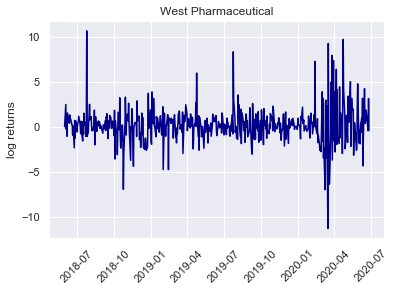

In [9]:
plt.plot(stocks['wst'], color = 'darkblue')
plt.xticks(rotation = 45)
plt.ylabel('log returns')
plt.title('West Pharmaceutical')

Text(0.5, 1.0, 'ServiceNow')

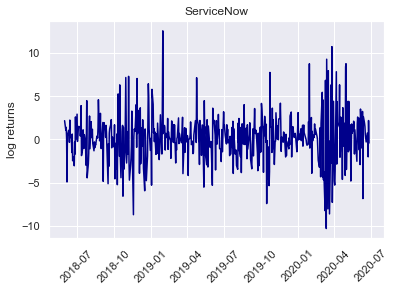

In [10]:
plt.plot(stocks['now'], color = 'darkblue')
plt.xticks(rotation = 45)
plt.ylabel('log returns')
plt.title('ServiceNow')

#### Comment
The three companies seem to observe similar time series trends in the recent period (from March 2020 i.e. the beginning of the COVID crisis in Europe and US). The variability of the log returns is large on a daily basis. 

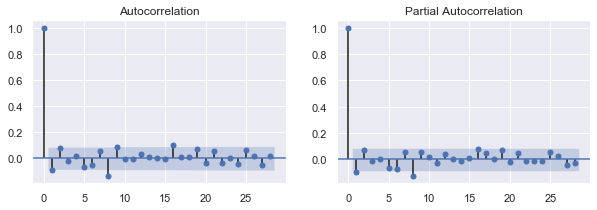

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sm.graphics.tsa.plot_acf(stocks['regn'], ax=ax[0])
sm.graphics.tsa.plot_pacf(stocks['regn'], ax=ax[1])
plt.show()

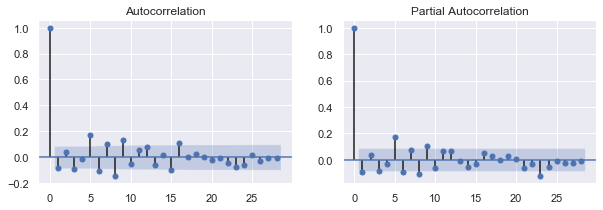

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sm.graphics.tsa.plot_acf(stocks['wst'], ax=ax[0])
sm.graphics.tsa.plot_pacf(stocks['wst'], ax=ax[1])
plt.show()

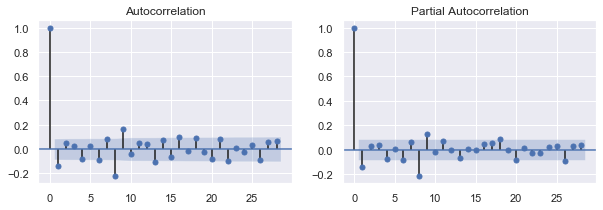

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sm.graphics.tsa.plot_acf(stocks['now'], ax=ax[0])
sm.graphics.tsa.plot_pacf(stocks['now'], ax=ax[1])
plt.show()

#### Comment 
There does not seem to be any autocorrelation or partial-autocorellation in REGN and WST (possibly lag orders of 0 or 1). For the NOW stock, the ACF and PACF clearly display a lag of order 1.  

### Correlation

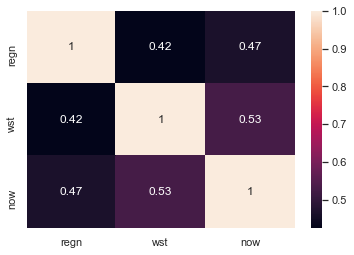

In [14]:
# calculate the correlation matrix
corr = stocks.corr()
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

#### Comment
The unconditional correlation of the values displays only a small correlation between the stocks, at most it is equal to 0.53. 

## Question 2
Make bivariate scatterplots for the three pairs of assets.

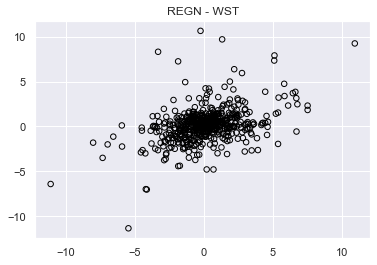

In [15]:
plt.scatter(stocks['regn'], stocks['wst'], s=30, facecolors='none', edgecolors='black')
plt.title('REGN - WST')
plt.show()

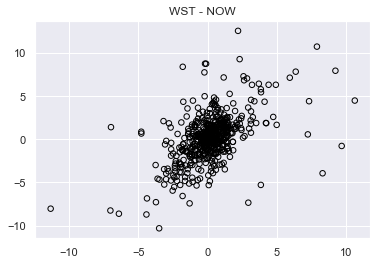

In [16]:
plt.scatter(stocks['wst'], stocks['now'], s=30, facecolors='none', edgecolors='black')
plt.title('WST - NOW')
plt.show()

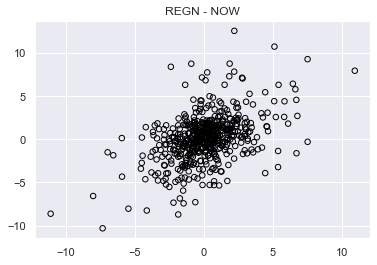

In [17]:
plt.scatter(stocks['regn'], stocks['now'], s=30, facecolors='none', edgecolors='black')
plt.title('REGN - NOW')
plt.show()

#### Comment: 
The correlation between the various stocks seems to be weak and positive. Given the typical values of logs returns, their high concentrations around 0 (i.e. small values) is typical. It is clear for all three shapes that some correlation exist (considering a loose cluster and a confidence ellipse). 

## Question 3
For each asset, estimate univariate GARCH models on the full sample with a normal innovation density.

In [19]:
from arch.univariate import arch_model
# GARCH model with normal innovation density
garchmodel_gaussian = arch_model(stocks['regn'], mean = 'Constant', vol='Garch', p=1, o=0, q=1, dist='normal')
model_fit = garchmodel_gaussian.fit()
print(model_fit.summary())
fig_regn_q3 = model_fit.conditional_volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1139.5726573768852
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1139.473919669409
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1139.4567962585706
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1139.4468899403346
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1139.3043950944727
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1139.18452075355
Iteration:      7,   Func. Count:     54,   Neg. LLF: 1139.0933310121345
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1139.0177272803585
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1139.013393280761
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1139.0117288893364
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1139.0117093774797
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1139.0117082124789
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1139.0117082134116
            Iterat

In [25]:
from arch.univariate import arch_model
# GARCH model with normal innovation density
garchmodel_gaussian = arch_model(stocks['wst'], mean = 'Constant', vol='Garch', p=1, o=0, q=1, dist='normal')
model_fit = garchmodel_gaussian.fit()
print(model_fit.summary())
fig_wst_q3 = model_fit.conditional_volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1035.2147247185267
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1034.4068525097439
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1034.3430803875426
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1033.9048383869501
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1033.607010265755
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1033.359137780118
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1033.1875049787416
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1033.0943815736623
Iteration:      9,   Func. Count:     66,   Neg. LLF: 1033.0407987017334
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1033.0288988633097
Iteration:     11,   Func. Count:     78,   Neg. LLF: 1033.0256104228733
Iteration:     12,   Func. Count:     84,   Neg. LLF: 1033.025569749322
Iteration:     13,   Func. Count:     90,   Neg. LLF: 1033.0255574417913
Optimization terminated successfully.    (Exit mode 0)

In [22]:
from arch.univariate import arch_model
# GARCH model with normal innovation density
garchmodel_gaussian = arch_model(stocks['now'], mean = 'Constant', vol='Garch', p=1, o=0, q=1, dist='normal')
model_fit = garchmodel_gaussian.fit()
print(model_fit.summary())
fig_now_q3 = model_fit.conditional_volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1227.8218997783797
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1227.6789410913227
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1227.6305650340114
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1227.566483086408
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1227.420718134275
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1227.3750373627538
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1227.3658337447046
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1227.3626686335183
Iteration:      9,   Func. Count:     62,   Neg. LLF: 1227.3626332816948
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1227.362632744295
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    now   R-squared:        

#### Comment 
For all three stocks, we fit a univariate GARCH model with contant mean, and normal distribution of the errors (normal innovation densities). We choose a GARCH(1,1) for each and note that the coefficients are significant (p-value < 0.05) only the constants of the REGN and NOW stocks do not seem valid. Based on the autocorrelation and partial autocorrelation plots, the AR portion of the model should be set to 0 or 1 (which is in line with our choice). In this case, p, o and q refer to the lag order of the symmetric innovation, lag order of the asymmetric innovation and lag order of lagged volatility or equivalent respectively. When increasing the value of the parameters (p, o and q), the p-value increases making the coefficients insignificant. 

## Question 4
Estimate a DCC model with univariate GARCH speciﬁcations for the variances.

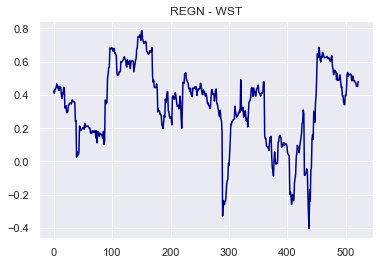

In [35]:
# EWMA in Python, as there is not a package for DCC
# subtract mean to the returns as we assume the returns model is a constant
regn = np.asarray(stocks['regn'] - stocks['regn'].mean())
wst = np.asarray(stocks['wst'] - stocks['wst'].mean())

mdata = np.zeros((stocks.shape[0], 2))
mdata[:,0] = regn
mdata[:,1] = wst

T = stocks.shape[0]
EWMA = np.full([T,3], np.nan)
variance_regn_wst = np.full([T,1], np.nan)
variance_wst_regn = np.full([T,1], np.nan)

# lambda can be changed to weight more the past variance or the past return
lmbda = 0.94
S = np.cov(mdata, rowvar = False)
EWMA[0,] = S.flatten()[[0,3,1]]

for i in range(1,T):
    S = lmbda * S + (1 - lmbda) * np.transpose(np.asmatrix(mdata[i-1]))* np.asmatrix(mdata[i-1])
    EWMA[i,] = [S[0,0], S[1,1], S[0,1]]
    variance_regn_wst[i,] = np.sqrt(S[0,0])
    variance_wst_regn[i,] = np.sqrt(S[1,1])
EWMArho_regn_wst = np.divide(EWMA[:,2], np.sqrt(np.multiply(EWMA[:,0],EWMA[:,1])))
plt.plot(EWMArho_regn_wst,color='darkblue')
plt.title('REGN - WST')
plt.show()

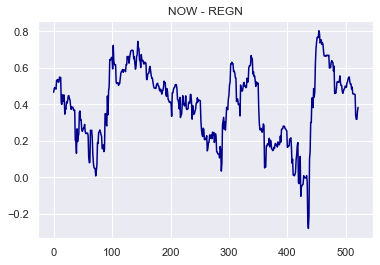

In [37]:
# EWMA in Python, as there is not a package for DCC
# subtract mean to the returns as we assume the returns model is a constant
regn = np.asarray(stocks['regn'] - stocks['regn'].mean())
now = np.asarray(stocks['now'] - stocks['now'].mean())

mdata = np.zeros((stocks.shape[0], 2))
mdata[:,0] = now
mdata[:,1] = regn

T = stocks.shape[0]
EWMA = np.full([T,3], np.nan)
variance_regn_now = np.full([T,1], np.nan)
variance_now_regn = np.full([T,1], np.nan)

# lambda can be changed to weight more the past variance or the past return
lmbda = 0.94
S = np.cov(mdata, rowvar = False)
EWMA[0,] = S.flatten()[[0,3,1]]

for i in range(1,T):
    S = lmbda * S + (1 - lmbda) * np.transpose(np.asmatrix(mdata[i-1]))* np.asmatrix(mdata[i-1])
    EWMA[i,] = [S[0,0], S[1,1], S[0,1]]
    variance_regn_now[i,] = np.sqrt(S[1,1])
    variance_now_regn[i,] = np.sqrt(S[0,0])
EWMArho_now_regn = np.divide(EWMA[:,2], np.sqrt(np.multiply(EWMA[:,0],EWMA[:,1])))
plt.plot(EWMArho_now_regn,color='darkblue')
plt.title('NOW - REGN')
plt.show()

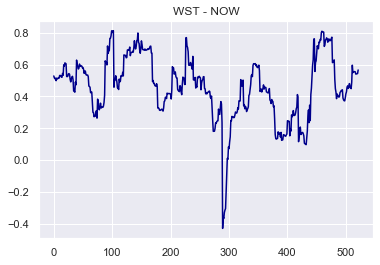

In [38]:
# EWMA in Python, as there is not a package for DCC
# subtract mean to the returns as we assume the returns model is a constant
now = np.asarray(stocks['now'] - stocks['now'].mean())
wst = np.asarray(stocks['wst'] - stocks['wst'].mean())

mdata = np.zeros((stocks.shape[0], 2))
mdata[:,0] = wst
mdata[:,1] = now

T = stocks.shape[0]
EWMA = np.full([T,3], np.nan)
variance_now_wst = np.full([T,1], np.nan)
variance_wst_now = np.full([T,1], np.nan)

# lambda can be changed to weight more the past variance or the past return
lmbda = 0.94
S = np.cov(mdata, rowvar = False)
EWMA[0,] = S.flatten()[[0,3,1]]

for i in range(1,T):
    S = lmbda * S + (1 - lmbda) * np.transpose(np.asmatrix(mdata[i-1]))* np.asmatrix(mdata[i-1])
    EWMA[i,] = [S[0,0], S[1,1], S[0,1]]
    variance_now_wst[i] = np.sqrt(S[1,1])
    variance_wst_now[i] = np.sqrt(S[0,0])
EWMArho_wst_now = np.divide(EWMA[:,2], np.sqrt(np.multiply(EWMA[:,0],EWMA[:,1])))
plt.plot(EWMArho_wst_now,color='darkblue')
plt.title('WST - NOW')
plt.show()

#### Comment
Python does not include a built in DCC model hence, following the instructions in the bivariate-GARCH.pynb file, we implement a EWMA model. The mean is substracted from the returns. The plots display the evolution of the correlation of the two variable studied over time. The EWMA model is a restricted integrated GARCH model (the intercept is set to 0). The smoothing parameter lambda is chosen as a rule of thumb as 0.94 for daily data. 

## Question 5 
Using plots, compare your univariate estimated variance series from the previous two questions.

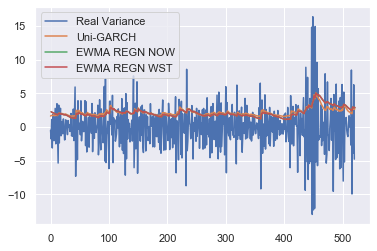

In [41]:
fig_regn_q3 = fig_regn_q3.reset_index()['cond_vol']
real = np.diff(stocks['regn'])
df = pd.DataFrame([real, fig_regn_q3, np.transpose(variance_regn_now)[0], np.transpose(variance_regn_wst)[0]]).transpose()
df.columns = ['Real Variance', 'Uni-GARCH', 'EWMA REGN NOW', 'EWMA REGN WST']
df.plot()

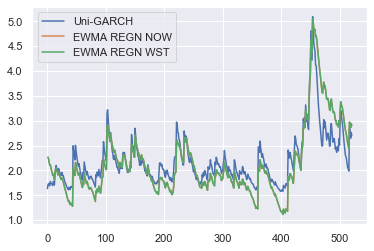

In [42]:
fig_regn_q3 = fig_regn_q3.reset_index()['cond_vol']
df = pd.DataFrame([fig_regn_q3, np.transpose(variance_regn_now)[0], np.transpose(variance_regn_wst)[0]]).transpose()
df.columns = ['Uni-GARCH', 'EWMA REGN NOW', 'EWMA REGN WST']
df.plot()

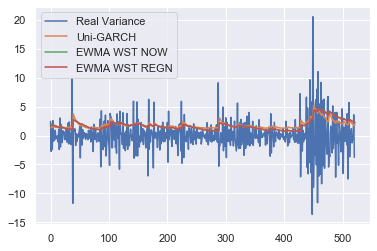

In [43]:
fig_regn_q3 = fig_wst_q3.reset_index()['cond_vol']
real = np.diff(stocks['wst'])
df = pd.DataFrame([real, fig_regn_q3, np.transpose(variance_wst_now)[0], np.transpose(variance_wst_regn)[0]]).transpose()
df.columns = ['Real Variance', 'Uni-GARCH', 'EWMA WST NOW', 'EWMA WST REGN']
df.plot()

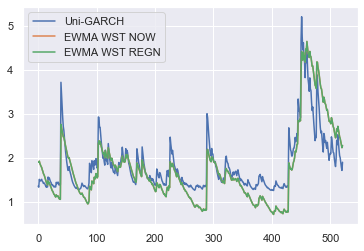

In [44]:
fig_regn_q3 = fig_wst_q3.reset_index()['cond_vol']
df = pd.DataFrame([fig_regn_q3, np.transpose(variance_wst_now)[0], np.transpose(variance_wst_regn)[0]]).transpose()
df.columns = ['Uni-GARCH', 'EWMA WST NOW', 'EWMA WST REGN']
df.plot()

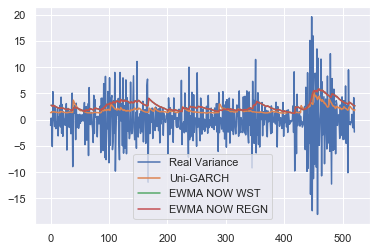

In [45]:
fig_regn_q3 = fig_wst_q3.reset_index()['cond_vol']
real = np.diff(stocks['now'])
df = pd.DataFrame([real, fig_regn_q3, np.transpose(variance_now_wst)[0], np.transpose(variance_now_regn)[0]]).transpose()
df.columns = ['Real Variance', 'Uni-GARCH', 'EWMA NOW WST', 'EWMA NOW REGN']
df.plot()

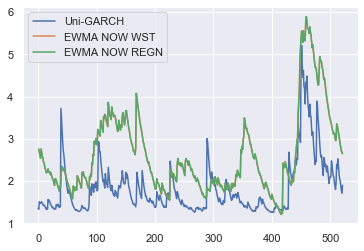

In [46]:
fig_regn_q3 = fig_wst_q3.reset_index()['cond_vol']
df = pd.DataFrame([fig_regn_q3, np.transpose(variance_now_wst)[0], np.transpose(variance_now_regn)[0]]).transpose()
df.columns = ['Uni-GARCH', 'EWMA NOW WST', 'EWMA NOW REGN']
df.plot()

#### Comment
The variance is computed as the difference between the log returns of a given day and the log returns of the day before. It is clear in all cases the data is very noisy. Both models are similar for the REGN and WST stocks. In both cases the EWMA model is slighly below the univariate GARCH and slightly smoother. The variances computed for the NOW stock vary a lot more from one another. The EWMA model is typically above the Univariate GARCH model. When comparing with the real variance, the Univariate GARCH seems to be a better approximation. This may be due to the smaller correlation of the NOW stock with both WST and REGN. 

## Question 6 
Make plots of the conditional correlation series. Interpret.

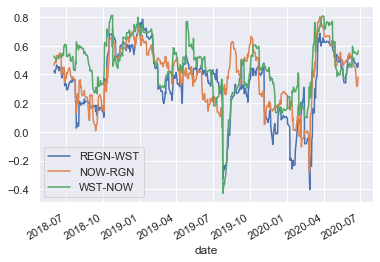

In [47]:
df = pd.DataFrame([EWMArho_regn_wst, EWMArho_now_regn, EWMArho_wst_now]).transpose()
df = df.set_index(stocks.reset_index()['date'])
df.columns = ['REGN-WST', 'NOW-RGN', 'WST-NOW']
df.plot()

#### Comment
The correlation plot above corresponds to the correlation computed between each couple of stocks over time. We expect a higher correlation towards the beginnong to middle of 2020, given the current events and since all firms benefited from the crisis, the correlation of their log-returns should be high. This is the case, especially in april where the correlations between all three stocks go up to 0.8. We would expect the pharmaceutical companies (REGN-WST) to have a higher correlation in general than with the workflow for companies firm (REGN-NOW, WST-NOW), it does not appear to be the case. Overall, the conditional correlations of the log returns of all three stocks seems to follow the same variations. 